This notebook partially reproduces the paper **"Stereo Magnification:  Learning View Synthesis using Multiplane Images"** from a Google team in 2018. It is based on [the code they published on github](https://github.com/google/stereo-magnification) as well as the [RealEstate10K dataset](https://google.github.io/realestate10k/) they also published.

I've *ported the code to PyTorch*, and *created a reduced version of the dataset*, which in combination with lowering the resolution and number of planes allows us to **train a model from scratch in this notebook in less than 15 minutes**. This model will be able to create Multi-Plane Images where we can see desirable characteristics such as the segmentation of planes by depth.

The original code was written in Tensorflow 1.X which is outdated, so I saw porting it to pytorch as an opportunity to both learn torch and give some value to the community. Also using the original dataset is not very easy, as only the metadata is provided and you need to write the code and run it to both download the (77k) youtube videos and capture the specific frames.

I've packaged the torch code and this notebook in [this github repo](https://github.com/Findeton/mpi_vision), and the reduced dataset (150 scenes for training, 50 for testing) in [this gitlab repo](https://gitlab.com/Findeton/real-estate-10k-run0).

**Motivation**

My main objective is being able to create novel views for a scene, in this case it's just a static scene captured by two images (thus "stereo vision") but hopefully in the future for dynamic scenes, possibly captured by many cameras.

This is really my first AI project as I've been studying DL on the side this year (thanks to [fast.ai](https://www.fast.ai/) btw), so excuse me if there's any mistake. As I delve into light-fields or computer vision, I chose trying to reproduce this paper because it seems to be a foundational one on which other ones like [deepview](https://augmentedperception.github.io/deepview/)/[deepview video](https://augmentedperception.github.io/deepviewvideo/) build upon. This year there's been a lot of [progress with NeRFs](https://github.com/yenchenlin/awesome-NeRF), which also allow you to create novel views. However even though there's some progress, it seems rendering NeRFs in real-time is still challenging so learning about MPIs is still valuable to me. I wonder if it would be useful to create MPIs from NeRFs, to enable faster rendering times.

**Clone the Dataset**

Let's start with cloning the reduced Real Estate dataset. I start with this because sometimes this step fails, probably because it's quite a big repo (4Gb), but don't despair if you retry it will probably work.

In [2]:
! git clone https://gitlab.com/Findeton/real-estate-10k-run0.git

fatal: destination path 'real-estate-10k-run0' already exists and is not an empty directory.


**Install dependencies**

Here we install PyTorch along with the FastAI library, which we'll use for easier training. This also clones the *mpi_vision* repo which includes math functions for creating the MultiPlane Image, Plane Sweep Volumes etc.

In [3]:
# install fastbook
! pip install -Uqq fastbook
! pip install transformations
import fastbook
fastbook.setup_book()
from fastbook import *

# Import some helper functions to do homographies etc, this code is translated from the paper's tensorflow code to pytorch
! git clone https://github.com/Findeton/mpi_vision.git
from  mpi_vision.utils import *
device = torch.device("cuda")

     |████████████████████████████████| 727kB 5.6MB/s 
     |████████████████████████████████| 194kB 31.3MB/s 
     |████████████████████████████████| 51kB 7.7MB/s 
     |████████████████████████████████| 1.1MB 30.2MB/s 
     |████████████████████████████████| 61kB 8.0MB/s 
     |████████████████████████████████| 51kB 2.9MB/s 
  Created wheel for transformations: filename=transformations-2020.1.1-cp36-cp36m-linux_x86_64.whl size=112421 sha256=8207cc3327f8ad1d76ea6ae6d813afc8f8a9f37da890425e0d4d549f7e8dbe59
  Stored in directory: /root/.cache/pip/wheels/fc/a5/f7/71b7eea1b7132ff12f28340e1780105328092fdcd8cbf9ee19
Successfully built transformations
Mounted at /content/gdrive
Cloning into 'mpi_vision'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 33 (delta 9), reused 25 (delta 5), pack-reused 0
Unpacking objects: 100% (33/33), done.


These are some helper functions to read the dataset.

In [4]:
def read_file_lines(filename):
  """Reads a text file, skips comments, and lines.

  Args:
    filename: the file to read
    max_lines: how many lines to combine into a single element. Any
      further lines will be skipped. The Dataset API's batch function
      requires this parameter, which is the batch size, so we set it to
      something bigger than our sequences.

  Returns:
    The lines of the file, as a 1-dimensional string tensor.
  """
  with open(filename) as f:
    lines = f.readlines()
    return [l.replace('\n', '') for l in lines if l[0] != '#']

def parse_camera_lines(lines):
  """Reads a camera file, returning a single ViewSequence (without images).

  Args:
    lines: [N] string tensor of camera lines

  Returns:
    The corresponding length N sequence, as a ViewSequence.
  """
  # The first line contains the YouTube video URL.
  # Format of each subsequent line: timestamp fx fy px py k1 k2 row0 row1  row2
  # Column number:                  0         1  2  3  4  5  6  7-10 11-14 15-18
  youtube_url = lines[0]
  record_defaults = ([['']] + [[0.0]] * 18)
  data = [ [float(n) if idx > 0 else int(n) for idx, n in enumerate(l.split(' ')) ] for l in lines[1:] ] # simple parse csv by splitting by space

  # We don't accept non-zero k1 and k2.
  assert(0 == len(list(filter(lambda x: x[5] != 0.0 or x[6] != 0.0, data))))

  timestamps = [l[0] for l in data]
  intrinsics = [ l[1:5] for l in data] #tf.stack(data[1:5], axis=1)
  poses = [ [l[7:11], l[11:15], l[15:19], [0., 0., 0., 1.]] for l in data ] # utils.build_matrix([data[7:11], data[11:15], data[15:19]])

  # In camera files, the video id is the last part of the YouTube URL, it comes
  # after the =.
  youtubeIDOffset = youtube_url.find("/watch?v=") + len('/watch?v=')
  youtube_id = youtube_url[youtubeIDOffset:]
  return {
      'youtube_id': youtube_id,
      'timestamps': timestamps,
      'intrinsics': intrinsics,
      'poses': poses, # poses is world to camera (c_f_w o w_t_c)
  }


**The Dataset** 

Here we define the dataset for PyTorch.Basically the input to the neural net is two images from two different camera views, one of them is re-projected into the camera view of the other one at different distances. That's called Plane Sweep Volume. We also use a third image from a different camera view, but that one is not passed to the neural net and instead is used to calculate the loss.

From the output of the NN we'll generate a Multi-Plane Image, which is a set of images with transparencies/alpha channels that we can use to easily render novel views just by basically creating a scene with the stack of images and moving our camera view at will. And actually just alpha-composition in 2D works, if you know what you're doing.

The real-estate-10k-run0 dataset has two parts, a list of txt files with metadata and the images. Each txt file includes a youtube ID and a list of frames with metadata. The metadata includes the frame timestamp, the 'pose' or world to camera matrix, and the camera intrinsics.

In the process of creating the dataset we're defining a couple of hyperparameters. As in the paper, I'm using a batch size of just 1. The resolution of the images we'll use is 224, and the number of planes is 10. I've also played with higher resolutions (480 pixels) and planes (33 planes) and it works, although it's slower, taking up to 6 minutes to train an epoch, instead of 40 seconds. Other implicit hyper-parameters are the minimum and maximum depths for the plane-sweep volume, in this case those are 1 and 100.

In [6]:
import os
import PIL

# fx, fy, cx, cy are simple scalars/floats
def make_intrinsics_matrix(fx, fy, cx, cy):
  return torch.Tensor([
    [fx, 0.0, cx],
    [0.0, fy, cy],
    [0.0, 0.0, 1.0]
  ]).to(device)

class RealEstateDataset(torch.utils.data.Dataset):
  def __init__(self, dataset_path, is_valid=False, min_dist=16e3, max_dist=500e3, img_size=224, num_planes=10):
    self.is_valid = is_valid
    self.dataset_path = dataset_path
    self.min_dist = min_dist
    self.max_dist = max_dist
    self.img_size = img_size
    self.num_planes = num_planes

    metadataBasePath = os.path.join(dataset_path, "RealEstate10K", "test" if is_valid else "train")
    self.scenes = [parse_camera_lines(read_file_lines(os.path.join(metadataBasePath,subPath))) for subPath in os.listdir(metadataBasePath)]
  
  def __len__(self): return len(self.scenes)
  
  def new_empty(self):
    return []
  
  def _draw(self, scene):
    img_range = range(len(scene['timestamps']))
    ref_img_idx = random.choice(img_range)
    base_timestamp = scene['timestamps'][ref_img_idx]
    near_range = list(filter(lambda i: abs(base_timestamp - scene['timestamps'][i]) >= self.min_dist and  abs(base_timestamp - scene['timestamps'][i]) <= self.max_dist, img_range))    
    assert(len(near_range) >= 2)

    src_img_idx = random.choice(near_range)
    tgt_img_idx = random.choice([i for i in near_range if i != src_img_idx])
    return [ref_img_idx, src_img_idx, tgt_img_idx]
  
  def __getitem__(self, i):
    scene = self.scenes[i]
    if self.is_valid:
      indexes = [0,1,2]
    else:
      indexes = self._draw(scene)
    
    selected_metadata = []
    for index in indexes:
      intrinsics = torch.Tensor(scene['intrinsics'][index]).to(device)
      new_intrinsics = make_intrinsics_matrix(
          self.img_size * intrinsics[0],
          self.img_size * intrinsics[1],
          self.img_size * intrinsics[2],
          self.img_size * intrinsics[3]
      )

      image_path = os.path.join(self.dataset_path, "transcode", scene['youtube_id'], "{}.jpg".format(scene['timestamps'][index]))
      img = PIL.Image.open(image_path).convert('RGB')
      scaled_image = img.resize((self.img_size, self.img_size))
      tensor_image = preprocess_image_torch(torch.Tensor(np.array(scaled_image)).to(device)/255.0)

      selected_metadata.append({
        'timestamp': scene['timestamps'][index],
        'intrinsics': new_intrinsics,
        'pose': torch.Tensor(scene['poses'][index]).to(device),
        'image': tensor_image
      })
    
    ref_img = selected_metadata[0] # this one will be fed to the nn without processing
    src_img = selected_metadata[1] # this will be fed to the nn as psv
    tgt_img = selected_metadata[2] # this is the dependent variable what the output should be
    
    psv_planes = torch.Tensor(inv_depths(1, 100, self.num_planes)).to(device)
    curr_pose = torch.matmul(src_img['pose'], torch.inverse(ref_img['pose']))
    curr_psv = plane_sweep_torch_one(src_img['image'], psv_planes, curr_pose, src_img['intrinsics'])
    
    net_input = torch.cat([torch.unsqueeze(ref_img['image'], 0), curr_psv], 3)
    dep_var = {
        'tgt_img_cfw': tgt_img['pose'],
        'tgt_img': tgt_img['image'],
        'ref_img': ref_img['image'],
        'ref_img_wfc': torch.inverse(ref_img['pose']),
        'intrinsics': src_img['intrinsics'],
        'mpi_planes': psv_planes
    }
    
    return [torch.squeeze(net_input).permute([2, 0, 1]), dep_var]

img_size=224
num_planes=10

def get_dataloaders(img_size, num_planes):
  train_ds = RealEstateDataset("./real-estate-10k-run0", img_size=img_size)
  valid_ds = RealEstateDataset("./real-estate-10k-run0", img_size=img_size, is_valid=True)

  from fastai.data.core import DataLoaders
  dls = DataLoaders.from_dsets(train_ds, valid_ds, device=device, num_workers=0, bs=1)
  return dls


dls = get_dataloaders(img_size, num_planes)
b = dls.one_batch()

print(b[0].shape)

torch.Size([1, 33, 224, 224])


**The CNN**

This is a standard U-Net CNN with three skip connections and instance normalization (as the batch size is one). The input to the CNN is the first image (3 channels) and the Plane Sweep Volume of the second image (3 times the number of planes). 

**The MPI**

The output of the CNN is 3 channels for a generated background image and another 2 times the number of planes of the final Multi-Plane Image. This has to do with how we're generating the MPI, as we see on the *mpi_from_net_output* method. Each plane of the MPI is generated by blending the generated background image and the input first image using a weight and and an alpha channel weight. We could instead require the CNN to generate the MPI directly, but the paper mentions this has worked best for them so that's what I'm using. Intuitively, using this method means constraining the search space for the MPI, which probably allows for a faster convergence, even though it probably limits the quality of the MPI.

In [7]:

class StereoMagnificationModel(Module):
  def __init__(self, num_mpi_planes):
    ngf = 3 + num_mpi_planes * 3
    nout = 3 + num_mpi_planes * 2
    self.ngf = ngf
    self.nout = nout
    self.cnv1_1 = ConvLayer(ngf,ngf, ks=3, stride=1, norm_type=InstanceNorm)                                  # 224
    self.cnv1_2 = ConvLayer(ngf,ngf*2, ks=3, stride=2, norm_type=InstanceNorm)                                # 112
    
    self.cnv2_1 = ConvLayer(ngf*2,ngf*2, ks=3, stride=1, norm_type=InstanceNorm)                              # 112
    self.cnv2_2 = ConvLayer(ngf*2,ngf*4, ks=3, stride=2, norm_type=InstanceNorm)                              # 56
    
    self.cnv3_1 = ConvLayer(ngf*4,ngf*4, ks=3, stride=1, norm_type=InstanceNorm)                              # 56
    self.cnv3_2 = ConvLayer(ngf*4,ngf*4, ks=3, stride=1, norm_type=InstanceNorm)                              # 56
    self.cnv3_3 = ConvLayer(ngf*4,ngf*8, ks=3, stride=2, norm_type=InstanceNorm)                              # 28
    
    self.cnv4_1 = ConvLayer(ngf*8,ngf*8, ks=3, stride=1, dilation=2, padding=2, norm_type=InstanceNorm)       # 28
    self.cnv4_2 = ConvLayer(ngf*8,ngf*8, ks=3, stride=1, dilation=2, padding=2, norm_type=InstanceNorm)       # 28
    self.cnv4_3 = ConvLayer(ngf*8,ngf*8, ks=3, stride=1, dilation=2, padding=2, norm_type=InstanceNorm)       # 28
    
    self.cnv5_1 = ConvLayer(ngf*16,ngf*4, ks=4, stride=2, transpose=True, padding=1, norm_type=InstanceNorm)  # 56
    self.cnv5_2 = ConvLayer(ngf*4,ngf*4, ks=3, stride=1, norm_type=InstanceNorm)                              # 56
    self.cnv5_3 = ConvLayer(ngf*4,ngf*4, ks=3, stride=1, norm_type=InstanceNorm)                              # 56
    
    self.cnv6_1 = ConvLayer(ngf*8,ngf*2, ks=4, stride=2, transpose=True, padding=1, norm_type=InstanceNorm)   # 112
    self.cnv6_2 = ConvLayer(ngf*2,ngf*2, ks=3, stride=1, norm_type=InstanceNorm)                              # 112
    
    self.cnv7_1 = ConvLayer(ngf*4,nout, ks=4, stride=2, transpose=True, padding=1, norm_type=InstanceNorm)    # 224
    self.cnv7_2 = ConvLayer(nout,nout, ks=3, stride=1, norm_type=InstanceNorm)                                # 224
    
    self.cnv8_1 = ConvLayer(nout,nout, ks=1, stride=1, norm_type=None, act_cls=nn.Tanh)                       # 224
  
  def forward(self, x):
    out_cnv1_1 = self.cnv1_1(x)
    out_cnv1_2 = self.cnv1_2(out_cnv1_1)
    
    out_cnv2_1 = self.cnv2_1(out_cnv1_2)
    out_cnv2_2 = self.cnv2_2(out_cnv2_1)
    
    out_cnv3_1 = self.cnv3_1(out_cnv2_2)
    out_cnv3_2 = self.cnv3_2(out_cnv3_1)
    out_cnv3_3 = self.cnv3_3(out_cnv3_2)
    
    out_cnv4_1 = self.cnv4_1(out_cnv3_3)
    out_cnv4_2 = self.cnv4_2(out_cnv4_1)
    out_cnv4_3 = self.cnv4_3(out_cnv4_2)
    
    # add skip connection
    in_cnv5_1 = torch.cat([out_cnv4_3, out_cnv3_3],1)
    
    out_cnv5_1 = self.cnv5_1(in_cnv5_1)
    out_cnv5_2 = self.cnv5_2(out_cnv5_1)
    out_cnv5_3 = self.cnv5_3(out_cnv5_2)
    
    # add skip connection
    in_cnv6_1 = torch.cat([out_cnv5_3, out_cnv2_2],1)
    
    out_cnv6_1 = self.cnv6_1(in_cnv6_1)
    out_cnv6_2 = self.cnv6_2(out_cnv6_1)
    
    # add skip connection
    in_cnv7_1 = torch.cat([out_cnv6_2, out_cnv1_2],1)
    
    out_cnv7_1 = self.cnv7_1(in_cnv7_1)
    out_cnv7_2 = self.cnv7_2(out_cnv7_1)
    
    out_cnv8_1 = self.cnv8_1(out_cnv7_2)
    
    return out_cnv8_1


# mpi_from_net_output
# Args:
#   mpi_pred: the output of the neural network  [batch, channels, height, width]
#   dep: the b[1] dependent variable
# Returns:
#   rgba_layers The layers  [batch, height, width, #planes, 4]
def mpi_from_net_output(mpi_pred, dep):
  # the following comes from infer_mpi():
  #################
  # Our default model. The network predicts: 1) weights for blending
  # the background and foreground (reference source image) color images
  # at each plane, 2) the alphas at each plane. 3) a background color
  # image.
  #print('mpi_pred.shape', mpi_pred.shape)
  batch_size, _, img_height, img_width = mpi_pred.shape
  # reshape mpi_pred to [batch, height, width, channels]
  mpi_pred = mpi_pred.permute(0, 2, 3, 1)
  #print('mpi_pred.shape', mpi_pred.shape)
  num_mpi_planes = dep['mpi_planes'].shape[1]
  # Rescale blend_weights to (0, 1)
  blend_weights = (mpi_pred[:, :, :, :num_mpi_planes] + 1.) / 2.
  # Rescale alphas to (0, 1)
  alphas = (
      mpi_pred[:, :, :, num_mpi_planes:num_mpi_planes * 2] + 1.) / 2.
  bg_rgb = mpi_pred[:, :, :, -3:]
  fg_rgb = dep['ref_img'].to(device)
  # Assemble into an MPI (rgba_layers)
  for i in range(num_mpi_planes):
    curr_alpha = torch.unsqueeze(alphas[:, :, :, i], -1)
    w = torch.unsqueeze(blend_weights[:, :, :, i], -1)
    curr_rgb = w * fg_rgb + (1 - w) * bg_rgb
    curr_rgba = torch.cat([curr_rgb, curr_alpha], dim=3)
    if i == 0:
      rgba_layers = curr_rgba
    else:
      rgba_layers = torch.cat([rgba_layers, curr_rgba], dim=3)
  rgba_layers = torch.reshape(
      rgba_layers, [batch_size, img_height, img_width, num_mpi_planes, 4])
  return rgba_layers

**Loss Functions**

An easy loss function is just the L2 loss between the third image and the generated one. I've kept that function as it's an interesting metric, but I'll be using the VGG loss instead for training.

Note: You can think of the MPI as a "window" into a scene. If the novel view we generate sees the "frame" of the window, the error/loss will never be zero. An improvement would be to take that into consideration and discard that loss, but AFAIK the derivative/chain role from those pixels to the model parameters  is still zero so it's just a cosmetic fix. 

In [9]:


# test_loss
# Args:
#   mpi_pred: the output of the neural network  [batch, channels, height, width]
#   dep: the b[1] dependent variable
def test_loss(mpi_pred, dep):
  rgba_layers = mpi_from_net_output(mpi_pred, dep)
  rel_pose = torch.matmul(dep['tgt_img_cfw'], dep['ref_img_wfc']).to(device)

  output_image  = mpi_render_view_torch(rgba_layers, rel_pose, dep['mpi_planes'][0], dep['intrinsics']).to(device)

  l2_loss_f =  MSELossFlat() # we could use torch.nn.MSELoss()

  return l2_loss_f(output_image, dep['tgt_img'].to(device)).to(device)

class VGGPerceptualLoss(torch.nn.Module):
    def __init__(self, resize=True, img_size=224):
        super(VGGPerceptualLoss, self).__init__()
        blocks = []
        blocks.append(torchvision.models.vgg16(pretrained=True).features[:4].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[4:9].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[9:16].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[16:23].eval())
        for bl in blocks:
            for p in bl.parameters():
                p.requires_grad = False
            
        self.blocks = torch.nn.ModuleList(blocks)
        self.transform = torch.nn.functional.interpolate

        self.mean_const = torch.tensor([0.485, 0.456, 0.406], device=device).view(1,3,1,1)
        self.std_const = torch.tensor([0.229, 0.224, 0.225], device=device).view(1,3,1,1)

        self.resize = resize
        self.img_size = img_size

    def forward(self, mpi_pred, dep): # input, target
        rgba_layers = mpi_from_net_output(mpi_pred, dep)
        rel_pose = torch.matmul(dep['tgt_img_cfw'], dep['ref_img_wfc'])
        
        input  = mpi_render_view_torch(rgba_layers, rel_pose, dep['mpi_planes'][0], dep['intrinsics'])
        target = dep['tgt_img']

        input = input.permute(0, 3, 1, 2)
        target = target.permute(0, 3, 1, 2)
        
        input = (input-self.mean_const) / self.std_const
        target = (target-self.mean_const) / self.std_const
        if self.resize:
            input = self.transform(input, mode='bilinear', size=(self.img_size, self.img_size), align_corners=False)
            target = self.transform(target, mode='bilinear', size=(self.img_size, self.img_size), align_corners=False)
        x = input
        y = target
        loss = torch.nn.functional.l1_loss(x, y)
        for i, block in enumerate(self.blocks):
            x = block(x)
            y = block(y)
            loss += torch.nn.functional.l1_loss(x, y) / (1+i)
        return loss


**Training**

This is really straight-forward. We'll simply use a FastAI learner with the defined dataset, model and loss. First we run a method to find a good learning rate and then we train the model for 20 epochs, which should take just 10 minutes.

SuggestedLRs(lr_min=0.33113112449646, lr_steep=1.0964781722577754e-06)

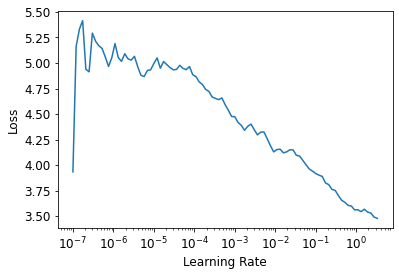

In [11]:
learn = Learner(dls, StereoMagnificationModel(num_planes), VGGPerceptualLoss(True, img_size).to(device), metrics=None)

learn.lr_find()

This validates the learning rate mentioned in the paper, 2e-4, so we'll be using that. You can see that at that point the loss has already started to decrease but there's still a long way to go down.

In [12]:
lr = 2e-4

learn.fit(20, lr=lr)

epoch,train_loss,valid_loss,time
0,2.762015,1.615919,00:41
1,2.740256,1.617082,00:41
2,2.726941,1.616143,00:41
3,2.380214,1.552734,00:41
4,2.406061,1.501382,00:41
5,2.272545,1.508373,00:40
6,2.383170,1.481958,00:41
7,2.202206,1.496119,00:40
8,2.276463,1.427202,00:40
9,2.113171,1.399229,00:40


**Testing**

Now let's get a batch as an example and generate an MPI with the model. Actually we'll hack around Google's html MPI Viewer for the [DeepView paper](https://augmentedperception.github.io/deepview) and use that to view the MPI inside the notebook! I recommend clicking on movement mode 'drag' and size 200%. You can also see the MPI layers at the bottom as well.


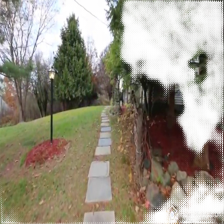
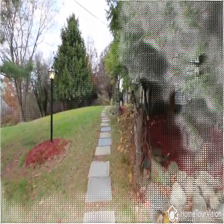
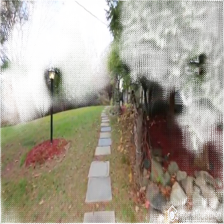
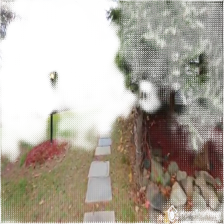
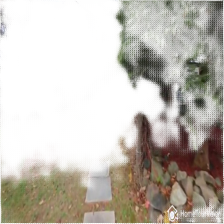
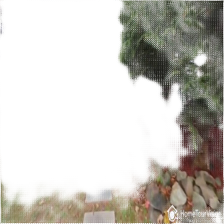
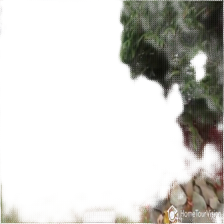
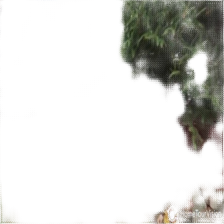
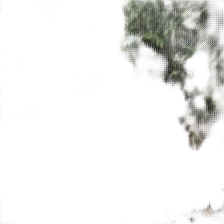
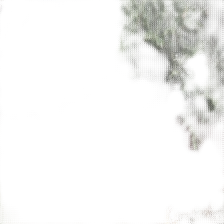

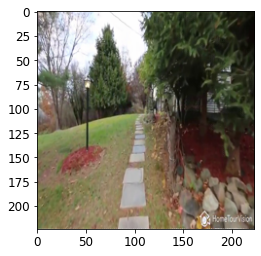

In [119]:
import matplotlib.pyplot as plt
import base64

# img: Tensor with shape [H, W, 4] and range [-1, +1]
# path: string path to (possibly new) file
def save_image(img, path):
  normalized_img = (img[:,:,:3]+1.0)/2.0
  normalized_img = torch.cat([normalized_img, img[:, :, 3:]], dim=2).permute(2,0,1)
  pilImg = torchvision.transforms.ToPILImage()( normalized_img )
  pilImg.save(path)
 
def get_base64_encoded_image(image_path):
    with open(image_path, "rb") as img_file:
        return "data:image/png;base64," + base64.b64encode(img_file.read()).decode('utf-8')

xb,yb = learn.dls.one_batch()
mpi_pred = learn.model(xb)
rgba_layers = mpi_from_net_output(mpi_pred, yb) # torch.Size([16, 224, 224, 10, 4])

for i in range(num_planes):
  layer = i
  rgba_layer = rgba_layers[0, :, :, layer,:3] * rgba_layers[0, :, :, layer,3:].repeat(1,1,3)
  save_image( rgba_layers[0, :, :, layer,:], "mpi_vision/mpi{}.png".format(  ("0" + str(layer))[-2:]  ))

image_srcs = [get_base64_encoded_image('./mpi_vision/mpi{}.png'.format( ("0" + str(i))[-2:] )) for i in range(num_planes) ]

with open("./mpi_vision/deepview-mpi-viewer-template.html", "r") as template_file:
  template_str = template_file.read()

MPI_SOURCES_DATA = ",".join(['\"' + img_src + '\"' for img_src in image_srcs])
template_str = template_str.replace("const mpiSources = MPI_SOURCES_DATA;", "const mpiSources = [{}];".format(MPI_SOURCES_DATA))

with open("./mpi_vision/deepview-mpi-viewer.html", "w") as output_file:
  output_file.write(template_str)

import IPython
IPython.display.HTML(filename='./mpi_vision/deepview-mpi-viewer.html')

**Final thoughts**

Excelent! I hope you enjoyed this notebook as much as I did! I think the results are impressive for training a model from scratch for just under 15 minutes. As the inputs are just two low-res images and the MPI has only 10 planes, the artifacts-free zone for the 'MPI window' is still quite limited. You can go further by increasing the number of planes to 33 and the resolution to 480 pixels, have fun! 

My next objective will be to reproduce some results of the [DeepView paper](https://augmentedperception.github.io/deepview), so see you soon!